In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

In [19]:
class KMeansClustering:
    def __init__(self, k=5, max_iters=100, tol=1e-4):
        self.k = k
        self.max_iters = max_iters
        self.tol = tol
        self.centroids = None
        self.labels = None

    def fit(self, X):
        # Randomly initialize centroids
        np.random.seed(42)
        random_indices = np.random.choice(len(X), size=self.k, replace=False)
        self.centroids = X[random_indices]

        for i in range(self.max_iters):
            # Assign each data point to the closest centroid
            self.labels = self.assign_labels(X)

            # Calculate new centroids
            new_centroids = self.calculate_centroids(X)

            # Check for convergence (if centroids do not change)
            if np.all(np.abs(new_centroids - self.centroids) < self.tol):
                break
            self.centroids = new_centroids

    def assign_labels(self, X):
        labels = []
        for point in X:
            distances = [np.linalg.norm(point - centroid) for centroid in self.centroids]
            labels.append(np.argmin(distances))
        return np.array(labels)

    def calculate_centroids(self, X):
        centroids = np.zeros((self.k, X.shape[1]))
        for i in range(self.k):
            centroids[i] = X[self.labels == i].mean(axis=0)
        return centroids

    def predict(self, X):
        # Predict the labels for new data points
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def calculate_wcss(self, X):
        # Calculate the within-cluster sum of squares (WCSS)
        wcss = 0
        for i in range(self.k):
            cluster_points = X[self.labels == i]
            wcss += np.sum(np.linalg.norm(cluster_points - self.centroids[i], axis=1) ** 2)
        return wcss


In [11]:
# Load the dataset
data = pd.read_csv('../Dataset/Mall_Customers.csv')

# Preview the dataset
print(data.head())

# Encode Gender: Male = 0, Female = 1 (Optional for clustering)
data['Gender'] = data['Gender'].apply(lambda x: 0 if x == 'Male' else 1)

# Select features for clustering (Age and Annual Income)
X = data[['Age', 'Annual Income (k$)']].values

# Feature scaling (Standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


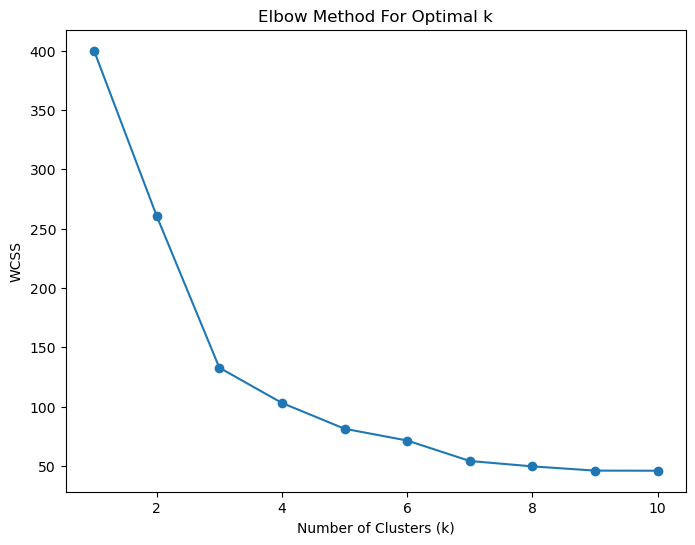

In [20]:
# Elbow Method to find the optimal k
wcss = []  # List to store the WCSS for each k
for k in range(1, 11):  # Try values of k from 1 to 10
    model = KMeansClustering(k=k)
    model.fit(X_scaled)
    wcss.append(model.calculate_wcss(X_scaled))  # WCSS for each k

# Plot Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

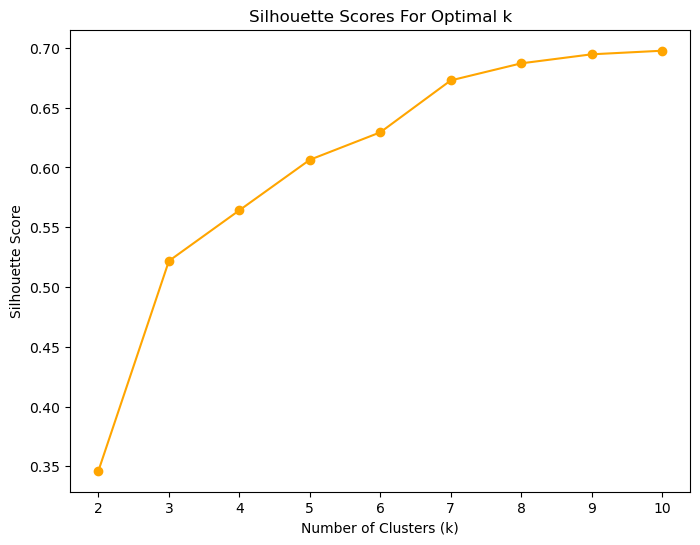

Silhouette Scores for each k:
k = 2, Score = 0.3463
k = 3, Score = 0.5218
k = 4, Score = 0.5641
k = 5, Score = 0.6064
k = 6, Score = 0.6293
k = 7, Score = 0.6728
k = 8, Score = 0.6870
k = 9, Score = 0.6946
k = 10, Score = 0.6976


In [26]:
# Function to calculate silhouette score
def calculate_silhouette_score(X, labels):
    n = len(X)
    silhouette_scores = []
    
    for i in range(n):
        # Find the points assigned to the same cluster
        own_cluster_points = X[labels == labels[i]]
        other_cluster_points = X[labels != labels[i]]
        
        # Cohesion: Mean distance to points in the same cluster
        a = np.mean(np.linalg.norm(own_cluster_points - X[i], axis=1))
        
        # Separation: Mean distance to points in the nearest different cluster
        b = np.min([np.mean(np.linalg.norm(other_cluster_points - X[i], axis=1)) for j in range(np.max(labels)+1) if j != labels[i]])
        
        # Silhouette score for this point
        s = (b - a) / max(a, b)
        silhouette_scores.append(s)
    
    # Return the average silhouette score
    return np.mean(silhouette_scores)

# Silhouette Score to find the optimal k
silhouette_scores = []  # List to store silhouette scores for each k
for k in range(2, 11):  # Silhouette score cannot be calculated for k=1
    model = KMeansClustering(k=k)
    model.fit(X_scaled)
    silhouette_score_val = calculate_silhouette_score(X_scaled, model.labels)
    silhouette_scores.append(silhouette_score_val)

# Plot Silhouette Scores
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

# Print silhouette scores
print("Silhouette Scores for each k:")
for k, score in zip(range(2, 11), silhouette_scores):
    print(f'k = {k}, Score = {score:.4f}')

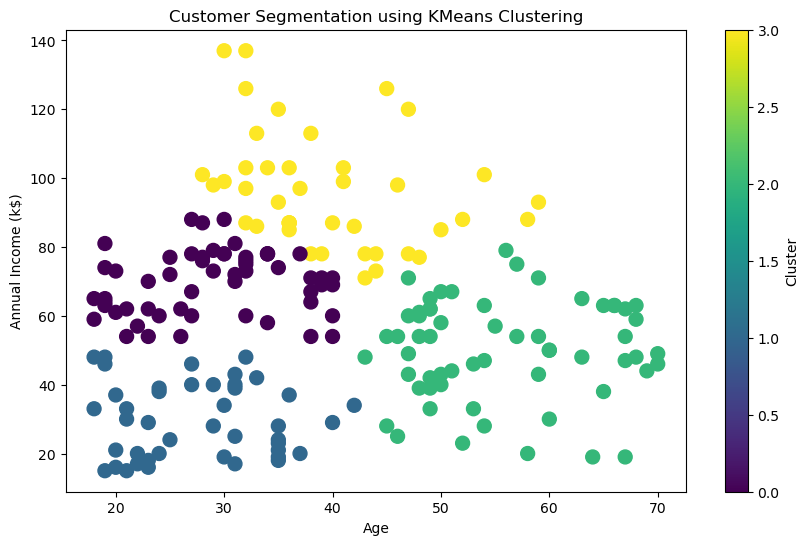

In [27]:
# Apply KMeansClustering to the dataset
kmeans = KMeansClustering(k=4)
kmeans.fit(X_scaled)

# Predict the cluster labels
y_pred = kmeans.predict(X_scaled)

# Add the predicted cluster labels to the original dataframe
data['Cluster'] = y_pred

# Visualizing the Clusters
plt.figure(figsize=(10, 6))
plt.scatter(data['Age'], data['Annual Income (k$)'], c=data['Cluster'], cmap='viridis', s=100)
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.title('Customer Segmentation using KMeans Clustering')
plt.colorbar(label='Cluster')
plt.show()
